In [1]:
# model library
import tensorflow as tf

# image processing libraries
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# data processing libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# folder reading libraries
import glob
import os

### Loading in model

In [2]:
model = tf.keras.models.load_model('../model/cyclic_voltammogram_model')

# add another layer to convert to probabilities
cv_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()]) # softmax layer converts inputs to probabilities


### Loading in experimental data

In [8]:
def gather_png_data(folder_path): # function to read in PNG image files
    files = glob.glob(folder_path + "/*.png")
    img_array = []
    l,t,r,b = 30,0,400,390 # left and top pixel until right and bottom pixel to crop that were arbitrarily set
    for img in files:
        img = load_img(img, color_mode = "grayscale")
        img = img.crop((l,t,r,b)) # cropping is better for model & training
        img = img_to_array(img)  # convert PIL format to numpy array (note: 255 is white and 0 black)
        img_array.append(img)
    img_array = np.array(img_array)
    # map values to 0-1 such that 0 represents white, 1 represents black: better for model to process since white is not needed
    img_array = -(img_array/255) + 1
    return np.squeeze(img_array)

def listdir_non_hidden(folder_path): # function to only gather non-hidden folders
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders

rel_folder_path = ("../data/experimental data/") # folder path of experimental data relative to code, note: add "/" at end
categories = listdir_non_hidden(rel_folder_path)
data = []
class_names = []

# iterates through data folder and appends data into a list
for folders in categories:
    datas = gather_png_data(rel_folder_path + folders)
    data.append(datas)

exp_data = np.vstack(data) 

# generates category labels based on training data folder names
training_folder = '../data/training data/data (E,v,lambda)/Line Plots'
data_folder = listdir_non_hidden(training_folder)
labels = []
for folders in data_folder:
    labels.append(folders)

In [10]:
exp_data = np.expand_dims(exp_data, axis = 0)

In [11]:
exp_data.shape

(1, 390, 370)

## Heatmap geneating functions

### Predicting data

In [12]:
predictions = cv_model.predict(exp_data, batch_size = 32)

1/1 [==============================] - 4s 4s/step


### Functions to display images

In [13]:
def display_predictions(i): # takes in the position of exprimental data 
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 2]}, figsize=(15,5))
    # first subplot
    ax[0].imshow(exp_data[i], cmap= "binary")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # second subplot 
    thisplot = ax[1].bar(range(len(labels)), predictions[i], color="#FFCCCB")
    ax[1].set_xticks(range(len(labels)))
    ax[1].set_yticks([])
    ax[1].set_ylim([0,1])
    predicted_label = np.argmax(predictions[i])
    thisplot[predicted_label].set_color('#90EE90')
    
    ax[1].set_title(f"Predicted Category: {predicted_label} ({labels[predicted_label]})", size = 20)
    # to label each bar with percentage on top   
    for i, v in enumerate(predictions[0]):
        ax[1].text(i - 0.5, v + 0.01, str(round(v*100,2)) + '%', color='blue', rotation = 45, size = 8)
    

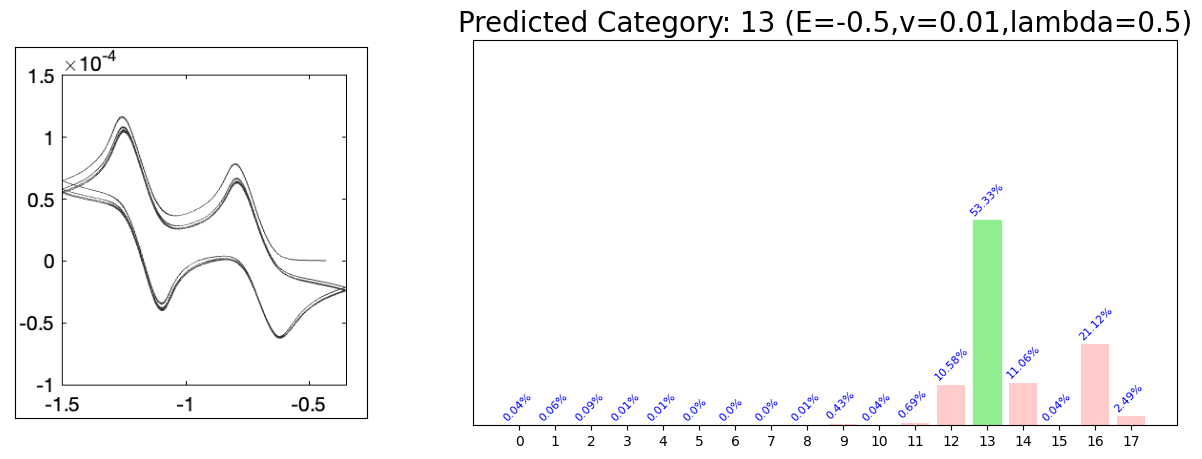

In [14]:
display_predictions(0)

### Heatmap - In progress

In [194]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size, color_mode = "grayscale")
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_size = (390, 370)

last_conv_layer_name = "dense_2"

# The local path to our target image
img_path = '../data/experimental data/E=test/1.png'

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()